In [1]:
# Importing necessary libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

from typing import List, Tuple
from collections import namedtuple
from sklearn.base import BaseEstimator, TransformerMixin #, clone
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from hyperopt import hp, STATUS_OK, tpe, fmin, Trials
import warnings
import regex as re

import joblib
import os
import json

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score

# Final Machine Learning Project Research Report
# Project Topic: Credit Card Fraud Detection using Machine Learning
# Project Supervisor: Soroush Sheikh

# Done by: Sahib Deep Singh


# Setting display options and ignoring warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [1]:
# setting up directories for better organizing trained models, reports and metrics
MODEL_DIR = './models/'
DATASET_DIR = './datasets/'
REPORTS_DIR = './metrics/performance'

# Loading Base Dataset

In [3]:
# load the raw dataset
base_dataset = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv', na_values= ['?', '$', '#', 'unknown', 'Unknown']).iloc[:, 1:]
print(f'Columns : {base_dataset.columns.tolist()}')
print(f'Shape : {base_dataset.shape}')

Columns : ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']
Shape : (1296675, 22)


In [4]:
# look at the label distribution - inspecting for label imbalance
base_dataset.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [5]:
# balancing the base dataset with equal number of fraud and non-fraud datapoints
not_fraud = base_dataset[base_dataset['is_fraud'] == 0].sample(n = 1500, random_state = 1)
is_fraud = base_dataset[base_dataset['is_fraud'] == 1].sample(n = 1500, random_state = 1)
del base_dataset
base_dataset_balanced = pd.concat([not_fraud, is_fraud], axis = 0).sample(n = 3000).reset_index(drop = True)


# REMOVE COMMENT BELOW
# base_dataset_balanced = pd.read_csv('./datasets/balanced_base_dataset.csv')
# base_dataset_balanced.head(2)

# segregating transaction (t_cols) and demographic-related (d_cols) columns
t_cols = 'trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud'.split(',')
d_cols = 'first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,is_fraud'.split(',')

# Loading Enrichment Dataset

In [6]:
# both base and enrichment dataset contains 3000 rows
nrows = 3000

#demog1 - adult census
e1 = pd.read_csv('/kaggle/input/adult-census-income/adult.csv', nrows = nrows , na_values= ['?', '$', '#', 'unknown', 'Unknown'])

# demog2 - us consumer finance complaints
e2 = pd.read_csv('/kaggle/input/us-consumer-finance-complaints/consumer_complaints.csv', nrows = nrows, na_values= ['?', '$', '#', 'unknown', 'Unknown'])

# # demog3 - amazon consumer behaviour dataset
# e3 = pd.read_csv('/kaggle/input/amazon-consumer-behaviour-dataset/Amazon Customer Behavior Survey.csv', nrows= nrows, na_values= ['?', '$', '#', 'unknown', 'Unknown'])

# demog3 - ecommerce-behavior-data-from-multi-category-store
e3 = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv', nrows= nrows, na_values= ['?', '$', '#', 'unknown', 'Unknown'])

# trans1 - online payments fraud detection
e4 = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv', nrows = nrows, na_values= ['?', '$', '#', 'unknown', 'Unknown'])

# trans2 - credit card transactions
e5 = pd.read_csv('/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv', nrows = nrows, na_values= ['?', '$', '#', 'unknown', 'Unknown'])

# trans3 - customer shopping dataset
e6 = pd.read_csv('/kaggle/input/customer-shopping-dataset/customer_shopping_data.csv', nrows = nrows, na_values= ['?', '$', '#', 'unknown', 'Unknown'])

e_df = pd.concat([e1, e2, e3, e4, e5, e6], axis =1) # e1.join([e2, e3, e4, e5, e6])
# e_df = pd.read_csv('./datasets/enrichment_data.csv')
print(f'Shape of the raw enrichment dataset : {e_df.shape}')

Shape of the raw enrichment dataset : (3000, 78)


In [8]:
e_df.head(2)

,workclass_DE,education_DE,marital.status_DE,relationship_DE,race_DE,hours.per.week_DE,income_DE,company_DE,tags_TE,product_id_TE,category_id_TE,category_code_TE,brand_TE,user_id_TE,user_session_TE,type_TE,Use Chip_TE,MCC_TE,shopping_mall_TE
0,NaN,HS-grad,Widowed,Not-in-family,White,40,<=50K,U.S. Bancorp,NaN,1003461,2053013555631882655,electronics.smartphone,xiaomi,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,PAYMENT,Swipe Transaction,5300,Kanyon
1,Private,HS-grad,Widowed,Not-in-family,White,18,<=50K,Wells Fargo & Company,NaN,5000088,2053013566100866035,appliances.sewing_machine,janome,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,PAYMENT,Swipe Transaction,5411,Forum Istanbul


### Cleaning the enrichment dataset 

In [15]:
# remove any traces of non-transaction related data
# segregate features into demographic/transactional
# eliminate any repeating features in enriched d_col or t_cols
cols_to_remove = ['amount', 'price', 'Amount', 'Zip', 'unix_time', 'Merchant City', 
                'Merchant State', 'Year', 'Month', 'Day', 'Time', 'invoice_date',
                'isFraud', 'isFlaggedFraud', 'Is Fraud?', 'invoice_no', 'nameOrig',
                'step', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 
                'newbalanceDest', 'User', 'Card', 'Errors?', 'customer_id', 'payment_method',
                'product', 'sub_product','education.num', 'capital.gain', 'captial.loss',
                'date_received', 'issue','sub_issue', 'consumer_complaint_narrative', 
                  'company_public_response','state', 'zipcode', 'consumer_consent_provided', 
                  'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 
                  'timely_response', 'consumer_disputed?', 'complaint_id', 'event_time', 'event_type',
                 ]

# filtering 1 - enriched dataset alignment to transaction -related data
e_df = e_df[e_df.columns[~e_df.columns.isin(cols_to_remove)]]

# filtering 2 - segregating refined enriched columns to d_cols and t_cols
d_cols_enriched = ['workclass', 'fnlwgt', 'education', 'marital.status',
                   'occupation', 'relationship', 'race', 'sex', 'hours.per.week',
                   'native.country', 'income', 'company', 'gender', 'age']

t_cols_enriched = ['tags', 'product_id', 'category_id', 'category_code', 
                   'brand', 'user_id', 'user_session', 'type', 'Use Chip',
                   'Merchant Name', 'MCC', 'category', 'quantity', 'shopping_mall']

# filtering 3 - toning down any overlapping column present in base d_cols and t_cols from enriched d_cols and t_cols
d_cols_to_remove = ['gender', 'native.country', 'fnlwgt', 'occupation', 'age', 'sex']
t_cols_to_remove = ['Merchant Name', 'category','quantity']

# final enrichment cols
d_cols_enriched = [col for col in d_cols_enriched if col not in d_cols_to_remove]
t_cols_enriched = [col for col in t_cols_enriched if col not in t_cols_to_remove]

# final enriched df contained enriched d_cols and t_cols
e_df = e_df[d_cols_enriched + t_cols_enriched]

tagged_t_cols = [f'{col}_TE' for col in t_cols_enriched]
tagged_d_cols = [f'{col}_DE' for col in d_cols_enriched]

# # final enriched dataset with columns tagged depending on demographic or transactional
e_df.columns = tagged_d_cols + tagged_t_cols
print(f'Shape of the cleaned enrichment dataset : {e_df.shape}')

Shape of the cleaned enrichment dataset : (3000, 19)


In [12]:
e_df.head(2)

,workclass_DE,education_DE,marital.status_DE,relationship_DE,race_DE,hours.per.week_DE,income_DE,company_DE,tags_TE,product_id_TE,category_id_TE,category_code_TE,brand_TE,user_id_TE,user_session_TE,type_TE,Use Chip_TE,MCC_TE,shopping_mall_TE
0,NaN,HS-grad,Widowed,Not-in-family,White,40,<=50K,U.S. Bancorp,NaN,1003461,2053013555631882655,electronics.smartphone,xiaomi,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,PAYMENT,Swipe Transaction,5300,Kanyon
1,Private,HS-grad,Widowed,Not-in-family,White,18,<=50K,Wells Fargo & Company,NaN,5000088,2053013566100866035,appliances.sewing_machine,janome,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,PAYMENT,Swipe Transaction,5411,Forum Istanbul


# Enrichment

Joining the base dataset and cleaned enrichment dataset to obtain the dataset that this analysis will be based on.

In [16]:
#creating master dataset by joining the base dataset and enrichment dataset
master_dataset = base_dataset_balanced[d_cols[:-1] + t_cols].join(e_df)
master_dataset.head(2)

,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_date_trans_time,cc_num,merchant,category,amt,trans_num,unix_time,merch_lat,merch_long,is_fraud,workclass_DE,education_DE,marital.status_DE,relationship_DE,race_DE,hours.per.week_DE,income_DE,company_DE,tags_TE,product_id_TE,category_id_TE,category_code_TE,brand_TE,user_id_TE,user_session_TE,type_TE,Use Chip_TE,MCC_TE,shopping_mall_TE
0,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,Tyler,TX,75703,32.2768,-95.3031,144160,Sports development officer,1984-05-04,2019-06-19 01:18:47,6506116513503136,fraud_Goodwin-Nitzsche,grocery_pos,347.88,7266fcbb0c6dedcff4aaca922fb3aa66,1340068727,32.063337,-94.562374,1,NaN,HS-grad,Widowed,Not-in-family,White,40,<=50K,U.S. Bancorp,NaN,1003461,2053013555631882655,electronics.smartphone,xiaomi,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,PAYMENT,Swipe Transaction,5300,Kanyon
1,Ellen,Carrillo,F,9431 Amanda Mills,Odessa,MO,64076,38.9829,-93.9757,9512,Clinical research associate,1972-12-31,2019-10-14 19:31:20,676314217768,"fraud_Kihn, Abernathy and Douglas",shopping_net,15.38,e1d3adfb522e1f1476f0b71a022be2ce,1350243080,39.142095,-93.700393,0,Private,HS-grad,Widowed,Not-in-family,White,18,<=50K,Wells Fargo & Company,NaN,5000088,2053013566100866035,appliances.sewing_machine,janome,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,PAYMENT,Swipe Transaction,5411,Forum Istanbul


In [17]:
print(f'Shape of the master dataset : {master_dataset.shape}')

Shape of the master dataset : (3000, 41)


# Preprocessing the master dataset

In [17]:
# check for missing values
missing_vals = round(master_dataset.isna().sum()/master_dataset.shape[0] * 100, 1)
missing_cols = missing_vals[missing_vals > 0].index.tolist()
print('Columns with missing values in %')
missing_vals[missing_vals > 0]

Columns with missing values in %


workclass_DE         3.4
tags_TE             85.9
category_code_TE    36.9
brand_TE            18.6
dtype: float64

## Segregate columns into categorical and numerical 

This is done to devise a strategy for handling missing values

In [18]:
# categorize columns into numerical and categorical cols

cat_cols = ['first', 'last', 'gender', 'street', 'city', 
            'state', 'zip', 'job', 'cc_num', 'merchant',
            'category', 'trans_num', 'workclass_DE', 'education_DE',
            'marital.status_DE', 'relationship_DE', 'race_DE'
            , 'hours.per.week_DE', 'income_DE', 'company_DE',
            'tags_TE', 'product_id_TE', 'category_id_TE', 'category_code_TE',
            'brand_TE', 'user_id_TE', 'user_session_TE', 'type_TE',
           'Use Chip_TE', 'MCC_TE', 'shopping_mall_TE']
num_cols = [col for col in master_dataset.columns.tolist() if (col not in cat_cols) and (col != 'is_fraud')]

# are all missing cols categorical ?
print([True if col in cat_cols else False for col in missing_cols])

[True, True, True, True]


## Handle missing values

Strategy chosen is as follows : 

1. If percentage of missing values is :
    
    a.  < 40 %, then drop the column
    
    b. >= 40 %, then impute the column using most frequent value

In [19]:
# Dropping columns with missing values less than 40%

# impute cols with missing values less than 40 % and dropping those with greater than that
master_dataset = base_dataset_balanced[d_cols[:-1] + t_cols].join(e_df)
master_dataset.drop(columns = ['tags_TE'], inplace = True)
# remove dropped column from cat_cols
cat_cols.remove('tags_TE')
tagged_t_cols.remove('tags_TE')

# Imputing columns with missing values greater than or equal to 40%
#define sequence of ops on cat cols -> complex or composite transformer
cat_col_transformer = Pipeline([
    ('mean_imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(dtype=int))
],)

cat_col_preprocessor = ColumnTransformer([
    ('cat_transformer', cat_col_transformer, cat_cols)
],
remainder='drop')

cat_col_encoding_transformer = ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(dtype = int), cat_cols)
],
remainder = 'drop')

# Apply the preprocessing steps to categorical columns
prepped_cat_df = pd.DataFrame(cat_col_preprocessor.fit_transform(master_dataset), columns = cat_cols)
prepped_cat_df.head(2)

,first,last,gender,street,city,state,zip,job,cc_num,merchant,category,trans_num,workclass_DE,education_DE,marital.status_DE,relationship_DE,race_DE,hours.per.week_DE,income_DE,company_DE,product_id_TE,category_id_TE,category_code_TE,brand_TE,user_id_TE,user_session_TE,type_TE,Use Chip_TE,MCC_TE,shopping_mall_TE
0,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,Tyler,TX,75703,Sports development officer,6506116513503136,fraud_Goodwin-Nitzsche,grocery_pos,7266fcbb0c6dedcff4aaca922fb3aa66,Private,HS-grad,Widowed,Not-in-family,White,40,<=50K,U.S. Bancorp,1003461,2053013555631882655,electronics.smartphone,xiaomi,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,PAYMENT,Swipe Transaction,5300,Kanyon
1,Ellen,Carrillo,F,9431 Amanda Mills,Odessa,MO,64076,Clinical research associate,676314217768,"fraud_Kihn, Abernathy and Douglas",shopping_net,e1d3adfb522e1f1476f0b71a022be2ce,Private,HS-grad,Widowed,Not-in-family,White,18,<=50K,Wells Fargo & Company,5000088,2053013566100866035,appliances.sewing_machine,janome,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,PAYMENT,Swipe Transaction,5411,Forum Istanbul


## Exploratory Data Analysis

This is done to prepare the dataset columns like analyzing which columns needs to be kept and removed, which needs to be transformed for better usability and visualization.

In [16]:
#combine numerical columns and preprocessed categorical df
eda_df = prepped_cat_df.join(master_dataset[num_cols + ['is_fraud']])
eda_df.head(2)

,first,last,gender,street,city,state,zip,job,cc_num,merchant,...,lat,long,city_pop,dob,trans_date_trans_time,amt,unix_time,merch_lat,merch_long,is_fraud
0,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,Tyler,TX,75703,Sports development officer,6506116513503136,fraud_Goodwin-Nitzsche,...,32.2768,-95.3031,144160,1984-05-04,2019-06-19 01:18:47,347.88,1340068727,32.063337,-94.562374,1
1,Ellen,Carrillo,F,9431 Amanda Mills,Odessa,MO,64076,Clinical research associate,676314217768,"fraud_Kihn, Abernathy and Douglas",...,38.9829,-93.9757,9512,1972-12-31,2019-10-14 19:31:20,15.38,1350243080,39.142095,-93.700393,0


In [17]:
# list of unwanted cols as they are unrelated to the analysis
unwanted_cols = ['first', 'last', 'street', 'unix_time', 'category_id_TE', 'category_code_TE'] # city - can be included

# columns that needs to change form for use in analysis
form_change_cols = ['dob', 'trans_date_trans_time']

# checking for columns with cardinality = 1 - to remove if any
for col in eda_df.columns[:-1]:
    if eda_df[col].unique().size <= 1 :
        print(f'Unique values in {col} : {eda_df[col].unique().size}')
        


In [18]:
# remove redundant cols
eda_df = eda_df[eda_df.columns[~eda_df.columns.isin(unwanted_cols)]]
print(f'Shape of the dataset after removing redundant columns : {eda_df.shape}')

Shape of the dataset after removing redundant columns : (3000, 34)


In [19]:
eda_df.head(2)

,gender,city,state,zip,job,cc_num,merchant,category,trans_num,workclass_DE,...,shopping_mall_TE,lat,long,city_pop,dob,trans_date_trans_time,amt,merch_lat,merch_long,is_fraud
0,F,Tyler,TX,75703,Sports development officer,6506116513503136,fraud_Goodwin-Nitzsche,grocery_pos,7266fcbb0c6dedcff4aaca922fb3aa66,Private,...,Kanyon,32.2768,-95.3031,144160,1984-05-04,2019-06-19 01:18:47,347.88,32.063337,-94.562374,1
1,F,Odessa,MO,64076,Clinical research associate,676314217768,"fraud_Kihn, Abernathy and Douglas",shopping_net,e1d3adfb522e1f1476f0b71a022be2ce,Private,...,Forum Istanbul,38.9829,-93.9757,9512,1972-12-31,2019-10-14 19:31:20,15.38,39.142095,-93.700393,0


In [20]:
eda_df['merchant'].apply(lambda x : x.split('_')[-1])

0                  Goodwin-Nitzsche
1       Kihn, Abernathy and Douglas
2                     Auer-Mosciski
3                      Botsford Ltd
4                       Barrows PLC
                   ...             
2995               Bechtelar-Rippin
2996        Lockman, West and Runte
2997          Yost, Block and Koepp
2998                  Kihn-Schuster
2999      Willms, Kris and Bergnaum
Name: merchant, Length: 3000, dtype: object

In [21]:
# handling columns that changes forms
eda_df['age'] = pd.Timestamp.now().year - pd.to_datetime(eda_df[form_change_cols[0]]).dt.year
eda_df['trans_datetime'] = pd.to_datetime(eda_df[form_change_cols[1]])
eda_df['trans_year'] = eda_df['trans_datetime'].dt.year
eda_df['trans_month'] = eda_df['trans_datetime'].dt.month_name()
eda_df['merchant'] = eda_df['merchant'].apply(lambda x : x.split('_')[-1])
eda_df.drop(columns = form_change_cols + ['trans_datetime'], inplace = True)
eda_df.head(2)

,gender,city,state,zip,job,cc_num,merchant,category,trans_num,workclass_DE,...,lat,long,city_pop,amt,merch_lat,merch_long,is_fraud,age,trans_year,trans_month
0,F,Tyler,TX,75703,Sports development officer,6506116513503136,Goodwin-Nitzsche,grocery_pos,7266fcbb0c6dedcff4aaca922fb3aa66,Private,...,32.2768,-95.3031,144160,347.88,32.063337,-94.562374,1,40,2019,June
1,F,Odessa,MO,64076,Clinical research associate,676314217768,"Kihn, Abernathy and Douglas",shopping_net,e1d3adfb522e1f1476f0b71a022be2ce,Private,...,38.9829,-93.9757,9512,15.38,39.142095,-93.700393,0,52,2019,October


In [22]:
# processing job description text to include designations alone
suffixes = ['opy','ake','ub','and','iate','ary',
            'son','sta', 'ath','geon','ner','wer',
            'fer','mer','nal','rew','ief','ler',
            'ker','der','cer','yer', 
            'ter', 'ist', 'per','ger', 
            'gner','tive','ect','eer','ian',
            'ant','her','ot','or','ser',
            'dic','rse','ney','yst','per']
re_pattern_v2 = '|'.join([r"\b(\w+%s\b)" %suffix for suffix in suffixes])
re_pattern_v2

eda_df['job'] = eda_df['job'].str.extract(re_pattern_v2, flags=re.IGNORECASE, expand = False).fillna(value='').sum(axis = 1).apply(lambda x : x.lower())


In [23]:
#get the final version of categorical, numerical, transactional and demographic cols

# update each col type with unwanted cols
cat_cols_final = cat_cols[:]
num_cols_final = num_cols[:]

t_cols_final = tagged_t_cols + t_cols[:-1]
d_cols_final = tagged_d_cols + d_cols[:-1]

for unwanted_col in unwanted_cols + form_change_cols + ['trans_datetime']:
    if unwanted_col in cat_cols:
        cat_cols_final.remove(unwanted_col)
        if unwanted_col in t_cols_final:
            t_cols_final.remove(unwanted_col)
        elif unwanted_col in d_cols_final:
            d_cols_final.remove(unwanted_col)
        else:
            pass
    elif unwanted_col in num_cols:
        num_cols_final.remove(unwanted_col)
        if unwanted_col in t_cols_final:
            t_cols_final.remove(unwanted_col)
        elif unwanted_col in d_cols_final:
            d_cols_final.remove(unwanted_col)
        else:
            pass
    else:
        pass
    
# update each of them with new cols
t_cols_final.extend(['trans_year', 'trans_month'])
d_cols_final.extend(['age'])

cat_cols_final.extend(['trans_year', 'trans_month'])
num_cols_final.extend(['age'])

In [32]:
# inspecting the number of different types of columsn
len(t_cols_final), len(d_cols_final), len(cat_cols_final), len(num_cols_final)

(17, 17, 27, 7)

In [24]:
# creating the preprocessed version of the dataset
eda_df = eda_df[d_cols_final + t_cols_final + ['is_fraud']]
print(f'Shape of the preprocessed dataset : {eda_df.shape}')

Shape of the preprocessed dataset : (3000, 35)


In [25]:
# TODO : remove this if required

eda_df.to_csv('/kaggle/working/eda_final_17_Apr_24.csv', index = False)

# Data Visualization 

This is done for descriptive analytics as well as to find potential strategy for feature engineering and finally modelling the data

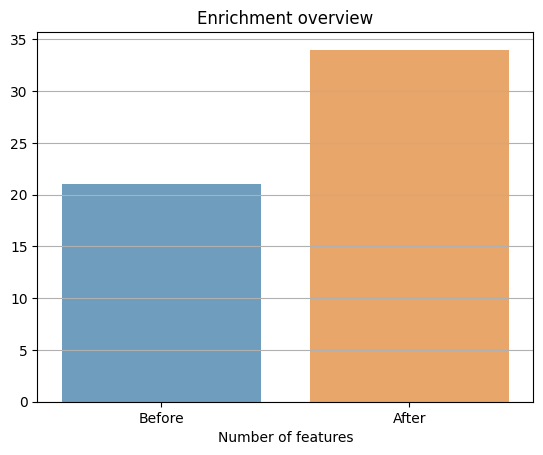

In [29]:
# Enrichment overview
n_features_0 = len(d_cols[:-1] + t_cols[:-1])
n_features_1 = len(d_cols_final + t_cols_final)
sns.barplot(x = ['Before', 'After'], y = [n_features_0, n_features_1], alpha = 0.7)
plt.grid(axis = 'y')
plt.xlabel('Number of features')
plt.title('Enrichment overview')
plt.show()

## Demography based visualizations

### Gender distribution for fraud

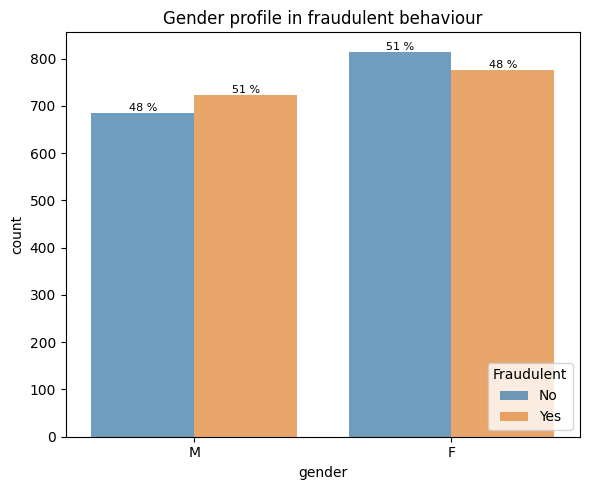

In [30]:
plt.figure(figsize = (6,  5))
ax = sns.countplot(data = eda_df, x = 'gender', hue = 'is_fraud', 
                          alpha = 0.7,
#                          palette = 'dark',
                        )
male_total_count = eda_df[eda_df['gender'] == 'M']['gender'].count()
female_total_count = eda_df[eda_df['gender'] == 'F']['gender'].count()
counter = 0
    
for p in ax.patches:
    xcoord = p.get_x() + p.get_width()/2
#     if counter % 2 == 0:
    ycoord = p.get_height()
    barheight = int(100 * p.get_height()/male_total_count)
    counter += 1
    if counter % 2 == 0:
        barheight = int(100 * p.get_height()/female_total_count)
    ax.text(xcoord, ycoord, f'{barheight} %', 
            fontsize=8, color='black', ha='center', va='bottom')
plt.title('Gender profile in fraudulent behaviour')
plt.legend(title = 'Fraudulent', labels = ['No', 'Yes'], loc = 'lower right')
plt.tight_layout()
plt.show()

__Observation__ : It can be seen that across genders, females are more related to Fraudulent transactions than males

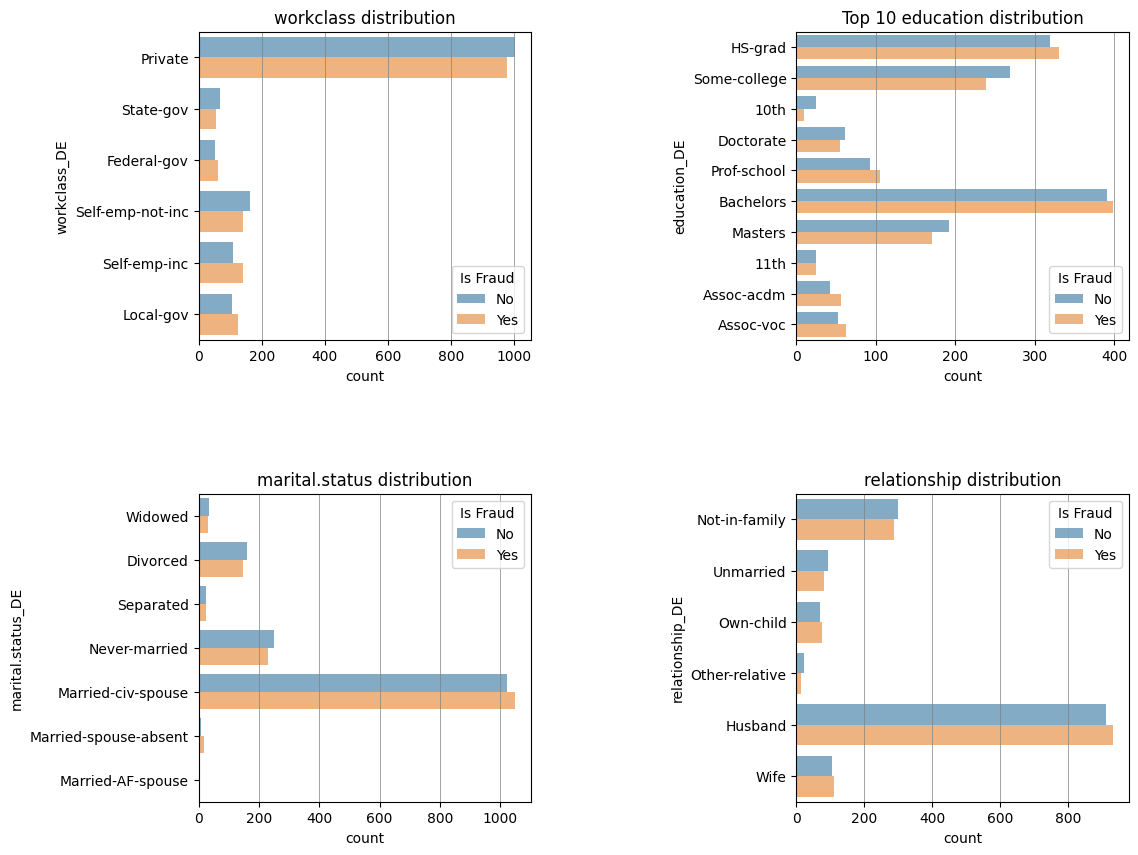

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
plt.subplots_adjust(wspace = 0.8, hspace = 0.5)
for ax, xlabel in zip(axes.flatten(), d_cols_final[:4]):
    if eda_df[xlabel].unique().size <= 15 :
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.countplot(eda_df, y = xlabel, hue = 'is_fraud', alpha = 0.6, ax = ax, orient = 'h')
    elif (eda_df[xlabel].unique().size <= 100) and (type(eda_df[xlabel][0]) == int):
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.histplot(eda_df, 
                     y = xlabel, 
                     hue = 'is_fraud',
                     multiple = 'dodge',
                     element = 'step',
                     alpha = 0.6,
                     ax = ax)
    else:
        top_k = 10
        ax.set_title(f'Top {top_k} {xlabel.split("_")[0]} distribution')
        freq_dist = eda_df[xlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[xlabel].isin(top_entities)], 
            y = xlabel, hue = 'is_fraud', ax = ax, orient = 'h', alpha = 0.6)
    ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
    ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])
plt.show()
    

__Observation__ (plots to be read in clockwise direction): 
1. Among working class type, private job is heavily related to fraudulent transactions while state-government job is less related with it
2. Considering education backbround, high school graduates and those with bachelors degree are found to be more involved with fraud
3. Among the kind of relationship, the role "husband" is more associated with fraud
4. For the variable marital status, those married to civilian spouse are more associated with fraud than others



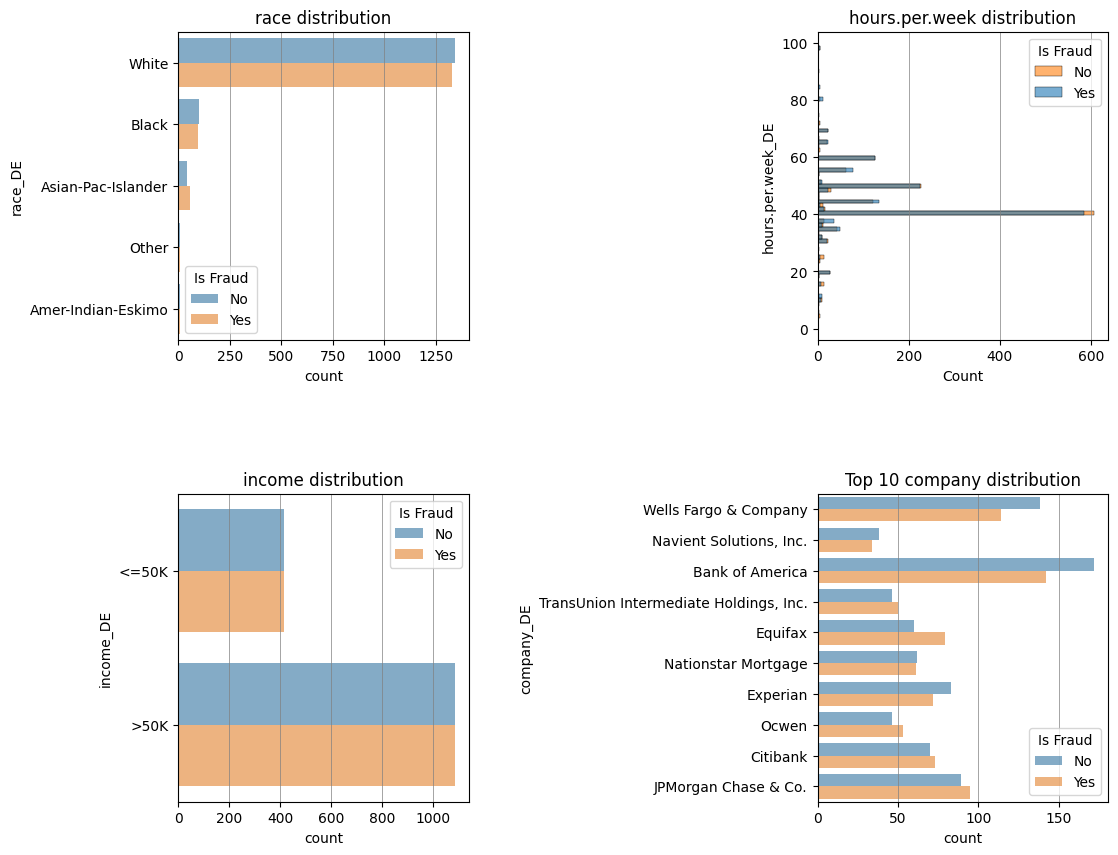

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
plt.subplots_adjust(wspace = 1.2, hspace = 0.5)
for ax, xlabel in zip(axes.flatten(), d_cols_final[4:8]):
    
    if eda_df[xlabel].unique().size <= 15 :
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.countplot(eda_df, y = xlabel, hue = 'is_fraud', alpha = 0.6, ax = ax, orient = 'h')
    elif (eda_df[xlabel].unique().size <= 100) and (type(eda_df[xlabel][0]) == int):
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.histplot(eda_df, 
                     y = xlabel, 
                     hue = 'is_fraud',
                     multiple = 'layer',
                     element = 'bars',
                     alpha = 0.6,
                     ax = ax)
    else:
        top_k = 10
        ax.set_title(f'Top {top_k} {xlabel.split("_")[0]} distribution')
        freq_dist = eda_df[xlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[xlabel].isin(top_entities)],
                      y = xlabel, 
                      hue = 'is_fraud', 
                      ax = ax, 
                      orient = 'h', 
                      alpha = 0.6)
    ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
    ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])

plt.show()
    

__Observation__ (plots to be read in clockwise direction): 
1. Race : Whites are more connected with fraud
2. Work hours : Those working about 40 hours a weeks appears to have more connection with fraud
3. Payment bank : Bank of America and Wells Fargo have highest fraud rates
4. Income distribution : Fraudulent activity is more prevalent people who earn more than $50000 per annum



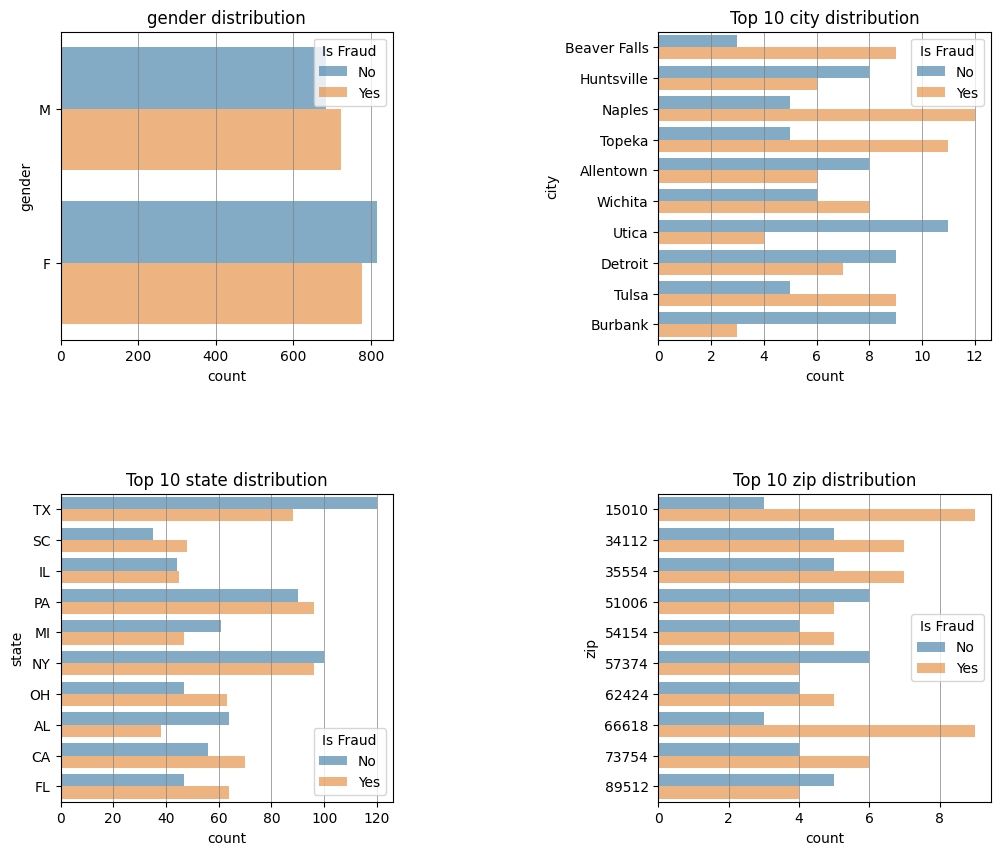

In [33]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
plt.subplots_adjust(wspace = 0.8, hspace = 0.5)
for ax, xlabel in zip(axes.flatten(), d_cols_final[8:12]):
    
    if eda_df[xlabel].unique().size <= 15 :
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.countplot(eda_df, y = xlabel, hue = 'is_fraud', alpha = 0.6, ax = ax, orient = 'h')
    elif (eda_df[xlabel].unique().size <= 100) and (type(eda_df[xlabel][0]) == int):
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.histplot(eda_df, 
                     y = xlabel, 
                     hue = 'is_fraud',
                     multiple = 'dodge',
                     element = 'step',
                     alpha = 0.6,
                     ax = ax)
    else:
        top_k = 10
        ax.set_title(f'Top {top_k} {xlabel.split("_")[0]} distribution')
        freq_dist = eda_df[xlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[xlabel].isin(top_entities)],
                      y = xlabel, 
                      hue = 'is_fraud', 
                      ax = ax, 
                      orient = 'h', 
                      alpha = 0.6)
    ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
    ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])

plt.show()
    

__Observation__ (plots to be read in clockwise direction): 
1. Gender : Females are more connected with fraud
2. Customer city : Cities Naples and Topeka are have been
3. Customer zip code : This gives more granular view of the top 10 location of fraudulent activities
4. Customer state of residence : A high level view of fraudulent activity among top 10 states



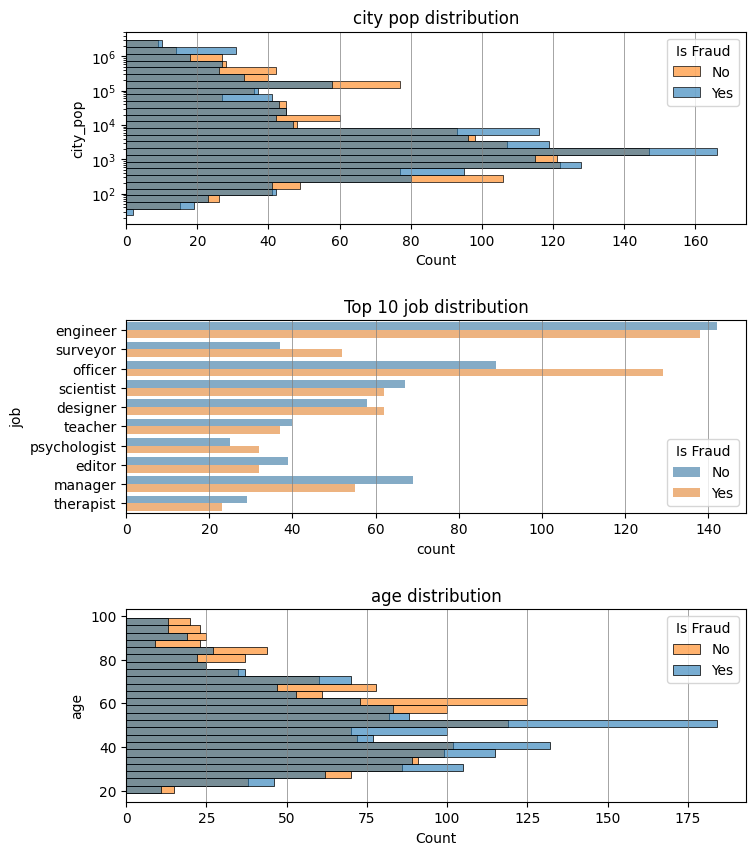

In [34]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 10))
plt.subplots_adjust(wspace = 0.8, hspace = 0.5)
for ax, xlabel in zip(axes.flatten(), d_cols_final[-3:]):
    
    if eda_df[xlabel].unique().size <= 100 :
        ax.set_title(f'{xlabel.split("_")[0]} distribution')
        sns.histplot(eda_df, y = xlabel, hue = 'is_fraud', alpha = 0.6, ax = ax)
    elif (eda_df[xlabel].unique().size <= 1000) and ((type(eda_df[xlabel][0]) == int) or (type(eda_df[xlabel][0]) == np.int32) or (type(eda_df[xlabel][0]) == np.int64)):
        unique_entries = eda_df[xlabel].unique().size
        binrange = None
        split_title = ' '.join(xlabel.split("_")[:2])
        ax.set_title(f'{split_title} distribution')
        sns.histplot(eda_df, 
                     y = xlabel, 
                     hue = 'is_fraud',
                     multiple = 'layer',
                     element = 'bars',
                     alpha = 0.6,
                     binrange = binrange,
                     log_scale = True,
                     ax = ax)
    else:
        top_k = 10
        ax.set_title(f'Top {top_k} {xlabel} distribution')
        freq_dist = eda_df[xlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[xlabel].isin(top_entities)],
                      y = xlabel, 
                      hue = 'is_fraud', 
                      ax = ax, 
                      orient = 'h', 
                      alpha = 0.6)
    ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
    ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])

plt.show()
    

__Observation__ (plots to be read in top to bottom direction): 
1. Customer city population : Fraudulent behaviour is more found in cities with population close to 1000 residents
2. Job designation of customer : Those performing as engineers and officer tend to be subjected to fraudulent activities more
3. Customer age : Customers in and around the age of 50 are subjected to fraudulent activites more



## Transaction based visualizations

In [36]:
#  'type_TE' - removed as it does not corresponds to credit card transaction data
vis_t_cols = [
 'brand_TE',
 'Use Chip_TE',
 'MCC_TE',
 'shopping_mall_TE',
 'merchant',
 'category',
 'amt',
 'trans_year',
 'trans_month']
len(vis_t_cols)

9

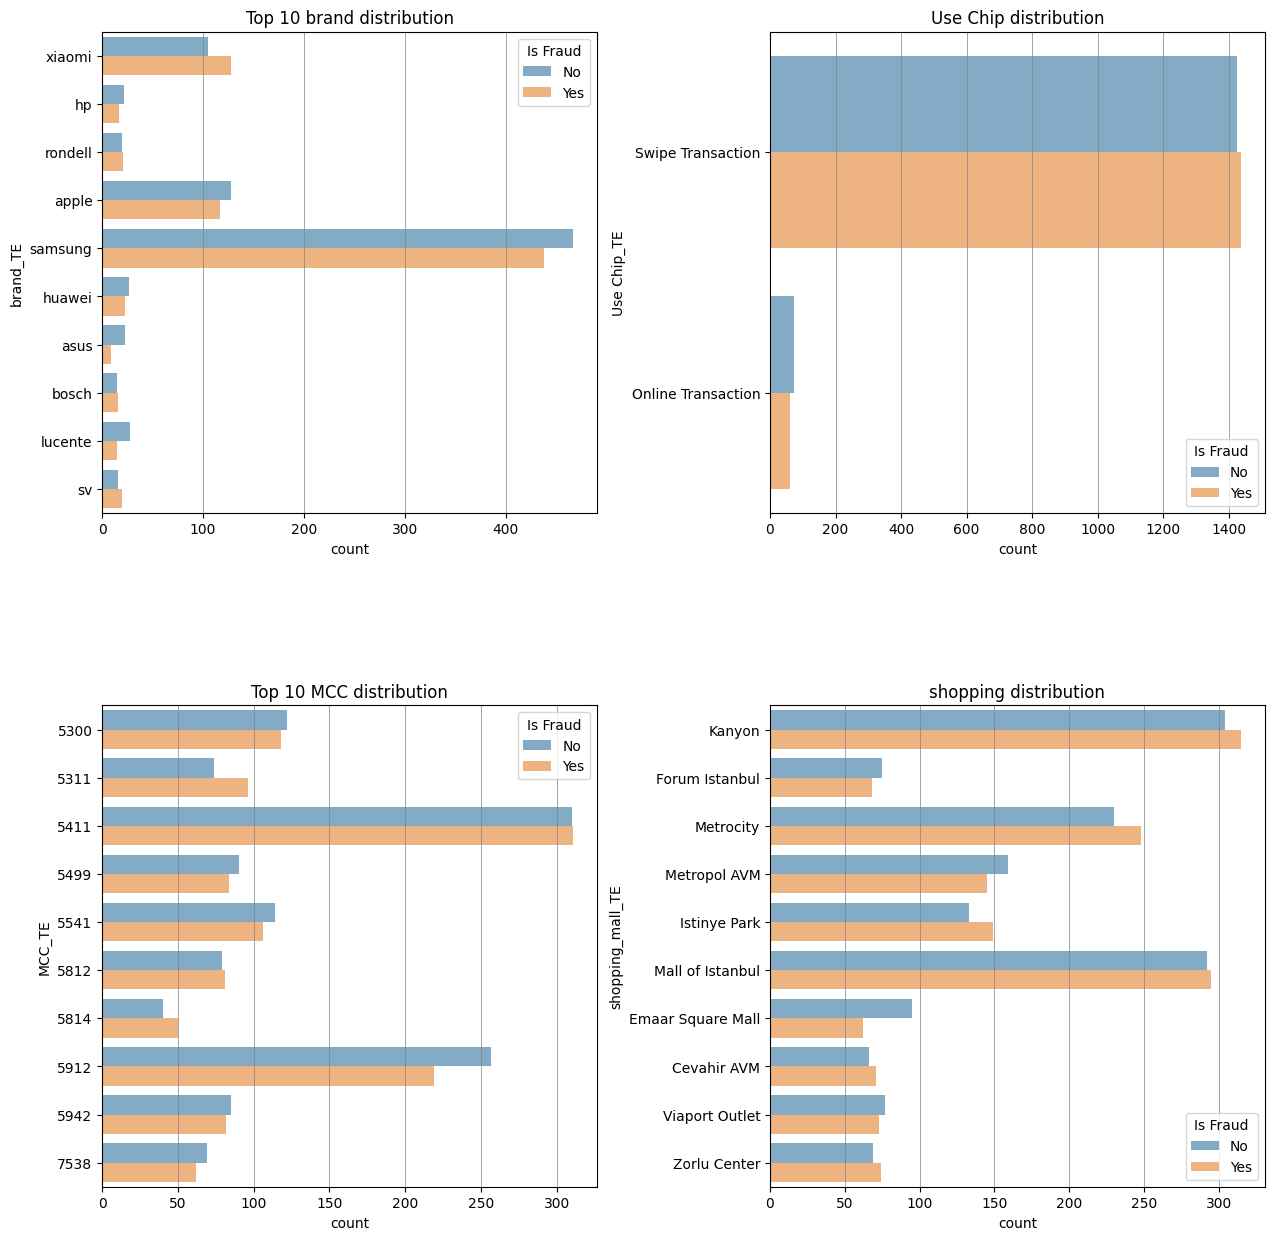

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
plt.subplots_adjust(wspace = 0.35, hspace = 0.4)
for ax, pltlabel in zip(axes.flatten(), vis_t_cols[:4]):

    
    label_cardinality = eda_df[pltlabel].unique().size
    int_types = (int, np.int16, np.int32, np.int64)
    
#     print(f'{pltlabel} cardinality : ', label_cardinality)
    #if col is categorical <= 15 cardinality
    if (label_cardinality <= 15) and (not isinstance(eda_df[pltlabel][0], int_types)):
        ax.set_title(f'{pltlabel.split("_")[0]} distribution')
        sns.countplot(eda_df, 
                      y = pltlabel, 
                      hue = 'is_fraud', 
                      alpha = 0.6, 
                      ax = ax, 
                      orient = 'h')
    
    #if col is categorical with > 15 cardinality
    elif (label_cardinality > 15) and (not isinstance(eda_df[pltlabel][0], int_types)):
        top_k = 10
        ax.set_title(f'Top {top_k} {pltlabel.split("_")[0]} distribution')
        freq_dist = eda_df[pltlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[pltlabel].isin(top_entities)],
                      y = pltlabel, 
                      hue = 'is_fraud', 
                      ax = ax, 
                      orient = 'h', 
                      alpha = 0.6)
    
    
    #if col is numerical with cardinality <= 100 and element dtype is any int
    elif (label_cardinality <=100) and isinstance(eda_df[pltlabel][0], int_types):
        
        if 'MCC' in pltlabel:
            top_k = 10
            ax.set_title(f'Top {top_k} {pltlabel.split("_")[0]} distribution')
            freq_dist = eda_df[pltlabel].value_counts(normalize = True) * 100
            top_entities = freq_dist[:top_k].index.tolist()
            sns.countplot(data = eda_df[eda_df[pltlabel].isin(top_entities)],
                          y = pltlabel, 
                          hue = 'is_fraud', 
                          ax = ax, 
                          orient = 'h', 
                          alpha = 0.6)
        else:
            ax.set_title(f'{pltlabel.split("_")[0]} distribution')
            sns.histplot(eda_df, 
                         y = pltlabel, 
                         hue = 'is_fraud',
                         alpha = 0.6, 
                         ax = ax)
        
    # if col is numerical with cardinatity <= 1000 and element dtype is any int
    elif (label_cardinality <= 3000) and isinstance(eda_df[pltlabel][0], int_types):
        ax.set_title(f'{pltlabel.split("_")[0]} distribution')
        sns.histplot(eda_df,
                    y = pltlabel,
                    hue = 'is_fraud',
                    alpha = 0.6,
                    log_scale = True,
                    ax = ax)
    ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
    ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])#, loc = 'center right', bbox_to_anchor = (-.3, 0.9)) #blue NO, Orange Yes

plt.show()

__Observation__ (plots to be read in clockwise direction): 
1. Product brand purchased : Fraudsters most commonly transact for samsung products
2. Transaction mode : Swipe mode of transaction has the most number of frauds reported
3. Purchase location : Shopping malls are the fraud hotspot with Mall of Istanbul at the top
4. Merchant Category Code (MCC) : 5411 (Grocery stores and supermarkets) is the dominant category subjected to fraudulent activities



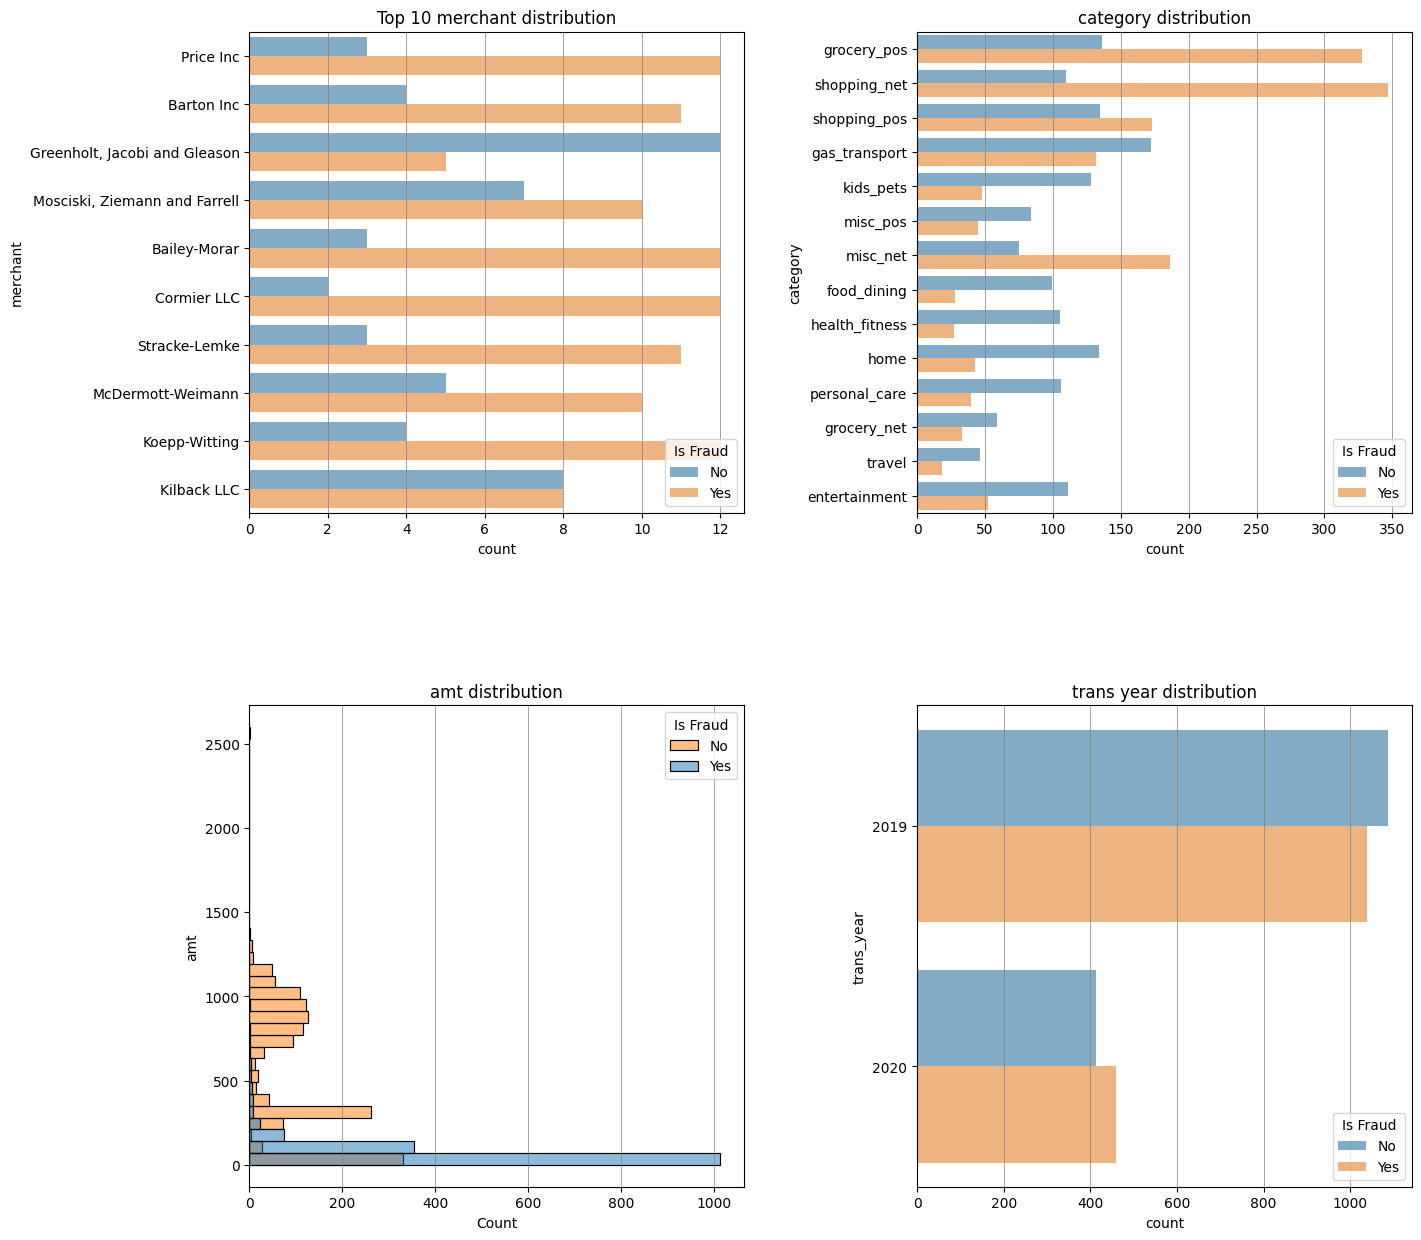

In [28]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,15))
plt.subplots_adjust(wspace = 0.35, hspace = 0.4)
for ax, pltlabel in zip(axes.flatten(), vis_t_cols[4:8]):

    
    label_cardinality = eda_df[pltlabel].unique().size
    int_types = (int, np.int16, np.int32, np.int64)
    float_types = (float, np.float16, np.float32, np.float64)
    
#     print(f'{pltlabel} cardinality : ', label_cardinality)
    
    # if col is float
    if isinstance(eda_df[pltlabel][0], float_types):
        ax.set_title(f'{pltlabel.split("_")[0]} distribution')
        sns.histplot(eda_df,
                    y = pltlabel,
                    hue = 'is_fraud',
                    alpha = 0.5,
                    ax = ax)
    
    
    #if col is categorical <= 15 cardinality
    elif (label_cardinality <= 15) and (not isinstance(eda_df[pltlabel][0], int_types)):
        ax.set_title(f'{pltlabel.split("_")[0]} distribution')
        sns.countplot(eda_df, 
                      y = pltlabel, 
                      hue = 'is_fraud', 
                      alpha = 0.6, 
                      ax = ax, 
                      orient = 'h')
    
    #if col is categorical with > 15 cardinality
    elif (label_cardinality > 15) and (not isinstance(eda_df[pltlabel][0], int_types)):
        top_k = 10
        ax.set_title(f'Top {top_k} {pltlabel.split("_")[0]} distribution')
        freq_dist = eda_df[pltlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[pltlabel].isin(top_entities)],
                      y = pltlabel, 
                      hue = 'is_fraud', 
                      ax = ax, 
                      orient = 'h', 
                      alpha = 0.6)
    
    
    #if col is numerical with cardinality <= 100 and element dtype is any int
    elif (label_cardinality <=100) and isinstance(eda_df[pltlabel][0], int_types):
        
        if 'MCC' in pltlabel:
            top_k = 10
            ax.set_title(f'Top {top_k} {pltlabel.split("_")[0]} distribution')
            freq_dist = eda_df[pltlabel].value_counts(normalize = True) * 100
            top_entities = freq_dist[:top_k].index.tolist()
            sns.countplot(data = eda_df[eda_df[pltlabel].isin(top_entities)],
                          y = pltlabel, 
                          hue = 'is_fraud', 
                          ax = ax, 
                          orient = 'h', 
                          alpha = 0.6)
        elif label_cardinality < 10:
            split_title = ' '.join(pltlabel.split("_")[:2])
            ax.set_title(f'{split_title} distribution')
            sns.countplot(eda_df,
                         y = pltlabel,
                         hue = 'is_fraud',
                         alpha = 0.6,
                         ax = ax)
            
        else:
            ax.set_title(f'{pltlabel.split("_")[0]} distribution')
            sns.histplot(eda_df, 
                         y = pltlabel, 
                         hue = 'is_fraud',
                         alpha = 0.6, 
                         ax = ax)
        
    # if col is numerical with cardinatity <= 1000 and element dtype is any int
    elif (label_cardinality <= 3000) and isinstance(eda_df[pltlabel][0], int_types):
        ax.set_title(f'{pltlabel.split("_")[0]} distribution')
        sns.histplot(eda_df,
                    y = pltlabel,
                    hue = 'is_fraud',
                    alpha = 0.6,
                    log_scale = True,
                    ax = ax)
    ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
    ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])#, loc = 'center right', bbox_to_anchor = (-.3, 0.9)) #blue NO, Orange Yes

plt.show()

__Observation__ (plots to be read in clockwise direction): 
1. Merchant Name : Price Inc, Baily Morar, Cornier-LLC and Koepp-Witting are the top names associate with fraudulent activities
2. Shopping category : Online shopping and POS-sale of grocery at the top category of fraud
3. Transaction year : 2019 has more report of fraud than the year 2020 (pandemic time)
4. Transaction value : Fraudulent activity is focused more at large number of small value transactions typically averaging about $250


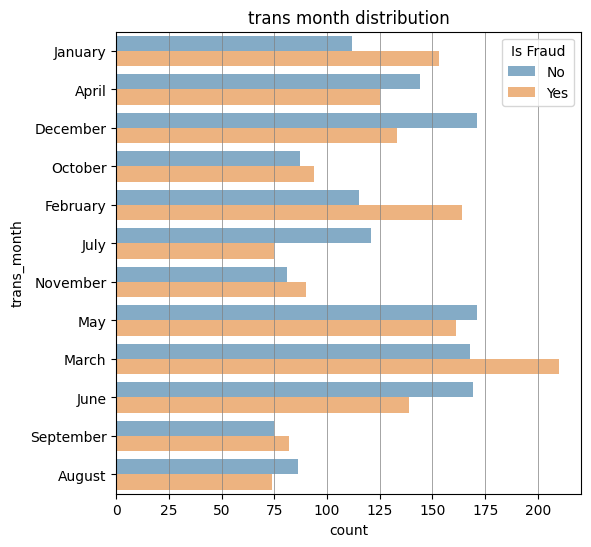

In [41]:
pltlabel = vis_t_cols[-1]
fig = plt.figure(figsize = (6,6))
ax = plt.gca()
    
label_cardinality = eda_df[pltlabel].unique().size
int_types = (int, np.int16, np.int32, np.int64)
float_types = (float, np.float16, np.float32, np.float64)

# print(f'{pltlabel} cardinality : ', label_cardinality)

# if col is float
if isinstance(eda_df[pltlabel][0], float_types):
    ax.set_title(f'{pltlabel.split("_")[0]} distribution')
    sns.histplot(eda_df,
                y = pltlabel,
                hue = 'is_fraud',
                alpha = 0.5,
                ax = ax)


#if col is categorical <= 15 cardinality
elif (label_cardinality <= 15) and (not isinstance(eda_df[pltlabel][0], int_types)):
    split_title = ' '.join(pltlabel.split("_")[:2])
    ax.set_title(f'{split_title} distribution')
    sns.countplot(eda_df, 
                  y = pltlabel, 
                  hue = 'is_fraud', 
                  alpha = 0.6, 
                  ax = ax, 
                  orient = 'h')

#if col is categorical with > 15 cardinality
elif (label_cardinality > 15) and (not isinstance(eda_df[pltlabel][0], int_types)):
    top_k = 10
    ax.set_title(f'Top {top_k} {pltlabel.split("_")[0]} distribution')
    freq_dist = eda_df[pltlabel].value_counts(normalize = True) * 100
    top_entities = freq_dist[:top_k].index.tolist()
    sns.countplot(data = eda_df[eda_df[pltlabel].isin(top_entities)],
                  y = pltlabel, 
                  hue = 'is_fraud', 
                  ax = ax, 
                  orient = 'h', 
                  alpha = 0.6)


#if col is numerical with cardinality <= 100 and element dtype is any int
elif (label_cardinality <=100) and isinstance(eda_df[pltlabel][0], int_types):
    if 'MCC' in pltlabel:
        top_k = 10
        ax.set_title(f'Top {top_k} {pltlabel.split("_")[0]} distribution')
        freq_dist = eda_df[pltlabel].value_counts(normalize = True) * 100
        top_entities = freq_dist[:top_k].index.tolist()
        sns.countplot(data = eda_df[eda_df[pltlabel].isin(top_entities)],
                      y = pltlabel, 
                      hue = 'is_fraud', 
                      ax = ax, 
                      orient = 'h', 
                      alpha = 0.6)
    elif label_cardinality <= 15:
        split_title = ' '.join(pltlabel.split("_")[:2])
        ax.set_title(f'{split_title} distribution')
        sns.countplot(eda_df,
                     y = pltlabel,
                     hue = 'is_fraud',
                     alpha = 0.6,
                     ax = ax)

    else:
        ax.set_title(f'{pltlabel.split("_")[0]} distribution')
        sns.histplot(eda_df, 
                     y = pltlabel, 
                     hue = 'is_fraud',
                     alpha = 0.6, 
                     ax = ax)

# if col is numerical with cardinatity <= 1000 and element dtype is any int
elif (label_cardinality <= 3000) and isinstance(eda_df[pltlabel][0], int_types):
    ax.set_title(f'{pltlabel.split("_")[0]} distribution')
    sns.histplot(eda_df,
                y = pltlabel,
                hue = 'is_fraud',
                alpha = 0.6,
                log_scale = True,
                ax = ax)
ax.xaxis.grid(True, which = 'major', linestyle = '-', color = 'gray', linewidth = 0.5)
ax.legend(title = 'Is Fraud', labels = ['No', 'Yes'])#, loc = 'center right', bbox_to_anchor = (-.3, 0.9)) #blue NO, Orange Yes

plt.show()

__Observation__ (plots to be read from top to bottom direction): 
1. Transaction month : March is the top month for fraud transactions



# Preparing Master Dataset 

## Encode categorical variables

Converting the categorical values to integers to facilitate the ML modeling process

In [29]:
cat_col_encoding_transformer= ColumnTransformer([('encoder', OrdinalEncoder(dtype = int), cat_cols_final)], remainder='passthrough')
cat_col_encoding_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', OrdinalEncoder(dtype=<class 'int'>),
                                 ['gender', 'city', 'state', 'zip', 'job',
                                  'cc_num', 'merchant', 'category', 'trans_num',
                                  'workclass_DE', 'education_DE',
                                  'marital.status_DE', 'relationship_DE',
                                  'race_DE', 'hours.per.week_DE', 'income_DE',
                                  'company_DE', 'product_id_TE', 'brand_TE',
                                  'user_id_TE', 'user_session_TE', 'type_TE',
                                  'Use Chip_TE', 'MCC_TE', 'shopping_mall_TE',
                                  'trans_year', 'trans_month'])])

In [30]:
# final_master_dataset 
encoded_master_cat = pd.DataFrame(cat_col_encoding_transformer.fit_transform(eda_df[cat_cols_final]), columns = cat_cols_final)
final_master_dataset = encoded_master_cat.join(eda_df[num_cols_final + ['is_fraud']], how = 'inner')
final_master_dataset.head(2)

,gender,city,state,zip,job,cc_num,merchant,category,trans_num,workclass_DE,education_DE,marital.status_DE,relationship_DE,race_DE,hours.per.week_DE,income_DE,company_DE,product_id_TE,brand_TE,user_id_TE,user_session_TE,type_TE,Use Chip_TE,MCC_TE,shopping_mall_TE,trans_year,trans_month,lat,long,city_pop,amt,merch_lat,merch_long,age,is_fraud
0,0,743,42,709,93,776,188,4,1341,2,11,6,1,4,32,0,341,22,357,195,229,3,1,28,4,0,6,32.2768,-95.3031,144160,347.88,32.063337,-94.562374,40,1
1,0,545,23,608,14,64,298,11,2650,2,11,6,1,4,13,0,359,503,162,255,428,3,1,31,2,0,10,38.9829,-93.9757,9512,15.38,39.142095,-93.700393,52,0


# Feature Engineering : Eliminating Less Informative features

Reducing the number of features to 60 % of the original one. During each step one most redundant feature gets eliminated until 60 % of them remains

In [32]:
feature_selector = RFE(DecisionTreeClassifier(), n_features_to_select= 0.6, step = 1)
X, y = final_master_dataset[d_cols_final + t_cols_final], final_master_dataset['is_fraud']
feature_selector.fit(X, y)
selected_feature_indices = np.where(feature_selector.ranking_ == 1)[0]
final_dataset_cols = final_master_dataset.columns[selected_feature_indices].tolist()
print(final_dataset_cols)

['gender', 'job', 'workclass_DE', 'education_DE', 'marital.status_DE', 'race_DE', 'hours.per.week_DE', 'income_DE', 'company_DE', 'product_id_TE', 'brand_TE', 'user_id_TE', 'user_session_TE', 'shopping_mall_TE', 'trans_year', 'trans_month', 'lat', 'long', 'city_pop', 'amt']


In [33]:
column_filter_func = lambda x, y : [val for val in x if val in y]

d_cols_final = column_filter_func(final_dataset_cols, d_cols_final)
t_cols_final = column_filter_func(final_dataset_cols, t_cols_final)

cat_cols_final = column_filter_func(final_dataset_cols, cat_cols_final)
num_cols_final = column_filter_func(final_dataset_cols, num_cols_final)

In [34]:
# DATASET_DIR = 'datasets'
final_master_dataset = final_master_dataset[d_cols_final + t_cols_final + ['is_fraud']]
final_master_dataset.to_csv(f'{DATASET_DIR}/final_master_dataset.csv', index =False)

In [48]:
final_master_dataset.head(2)

,gender,state,workclass_DE,education_DE,marital.status_DE,race_DE,hours.per.week_DE,income_DE,company_DE,lat,long,city_pop,age,product_id_TE,user_id_TE,user_session_TE,shopping_mall_TE,trans_year,trans_month,amt,is_fraud
0,1,17,2,11,6,4,32,0,341,30.0252,-90.2522,68211,90,22,195,229,4,1,4,928.47,1
1,0,42,2,11,6,4,13,0,359,29.7972,-95.3288,2906700,41,503,255,428,2,0,0,34.99,0


In [49]:
final_master_dataset.shape

(3000, 21)

# Build HCCFD Model Variant 1 : Mixed Feature Model

This variant makes use of the dataset that contains both the transactional and demographic features of the master dataset

## Partitioning dataset into train and test

Splitting ratio is train : test :: 80 : 20

In [8]:
#splitting dataset
predictors = d_cols_final + t_cols_final
target = ['is_fraud']
X, y = final_master_dataset[predictors], final_master_dataset[target]
test_split_ratio = 0.2
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = test_split_ratio, random_state = 10)

In [10]:
def get_baseline_accuracy(fitted_model, xtrain, xtest, ytrain, ytest):
    train_acc, test_acc = round(fitted_model.score(xtrain, ytrain) * 100, 2), round(fitted_model.score(xtest, ytest) * 100, 2)
    return train_acc, test_acc

In [11]:
def show_accuracy(train_test_accuracy):
    train_acc, test_acc = train_test_accuracy
    print(f'Train Acc : {train_acc:3.2f} %', end = ' || ')
    print(f'Test Acc : {test_acc:3.2f} %')

## <center>Decision Tree</center>

## Baseline Model

In [50]:
# baseline model
# dt
dt = DecisionTreeClassifier(random_state = 10)
dt.fit(xtrain, ytrain)

train_preds = dt.predict(xtrain)
test_preds = dt.predict(xtest)

dt_baseline_accuracy = get_baseline_accuracy(dt, xtrain, xtest, ytrain, ytest)
show_accuracy(dt_baseline_accuracy)

Train Acc : 100.00 % || Test Acc : 84.50 %


## Probabilistic Analysis

In [12]:
TARGET_LABELS = {0 : 'Not Fraud', 1 : 'Fraud'}
def show_classification_report(ytrue, ypred):
    report= classification_report(y_true= ytrue, y_pred= ypred, output_dict = True)
    final_report = {}
    for report_key, report_value in report.items():
        if report_key.isnumeric():
            if int(report_key) in list(TARGET_LABELS.keys()):
                final_report[TARGET_LABELS[int(report_key)]] = report_value
    return pd.DataFrame(final_report)

In [13]:
def show_roc_auc_score(ytrain, trainpreds, ytest, testpreds):
    print(f'Train ROC-AUC score : {roc_auc_score(ytrain, trainpreds):.3f} ', end = ' || ')
    print(f'Test ROC-AUC score : {roc_auc_score(ytest, testpreds) :.3f}')

In [14]:
def show_cv_score(fitted_model, xtrain, ytrain):
    cv_score = cross_val_score(fitted_model, xtrain, ytrain).mean() * 100
    print(f'Train Cross validation Acc : {cv_score :.3f} %')

In [51]:
dt_train_report = show_classification_report(ytrain, train_preds)
dt_train_report

,Not Fraud,Fraud
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1215.0,1185.0


In [52]:
dt_test_report = show_classification_report(ytest, test_preds)
dt_test_report

,Not Fraud,Fraud
precision,0.817881,0.872483
recall,0.866667,0.825397
f1-score,0.841567,0.848287
support,285.000000,315.000000


In [53]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 1.000  || Test ROC-AUC score : 0.846


In [54]:
show_cv_score(dt, xtrain, ytrain)

Train Cross validation Acc : 83.000 %


In [55]:
# save trained model
joblib.dump(dt, os.path.join(MODEL_DIR, 'baseline_dt.joblib'))

['./models/baseline_dt.joblib']

## HyperParameter Tuning

In [15]:
def test_model_with_best_params(model_obj, best_params):
    model = model_obj(**best_params)
    model.fit(xtrain, ytrain)
    
    train_acc_score, test_acc_score = round(model.score(xtrain, ytrain) * 100,2), round(model.score(xtest, ytest) * 100, 2)
    return train_acc_score, test_acc_score, model
    

In [103]:
def dt_objective_fn(params_to_tune):
    decision_tree = DecisionTreeClassifier(**params_to_tune)
    accuracy_score = cross_val_score(decision_tree, xtrain, ytrain, cv = 5).mean()
    return {'loss': -accuracy_score , 'status' : STATUS_OK}

# hyperparameter search space as python dict
tune_params = ['criterion', 'min_samples_split']
search_space = {
    'criterion' : hp.choice('criterion', ["gini", "entropy", "log_loss"]),
    'min_samples_split' : hp.uniform('min_samples_split', 0.01, 1.0)
}

trials = Trials()
best_params = fmin(fn = dt_objective_fn, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 25,
                  trials = trials,
                  rstate = np.random.seed(10))
best_params

100%|██████████| 25/25 [00:02<00:00, 11.39trial/s, best loss: -0.8775000000000001]


{'criterion': 0, 'min_samples_split': 0.2702447741874797}

In [57]:
best_params['criterion'] = ["gini", "entropy", "log_loss"][best_params['criterion']]
best_params

{'criterion': 'gini', 'min_samples_split': 0.2702447741874797}

In [58]:
dt_tuned_artifacts  = test_model_with_best_params(DecisionTreeClassifier, best_params)
dt_tuned_accuracy, dt_tuned = dt_tuned_artifacts[:2], dt_tuned_artifacts[-1]
show_accuracy(dt_tuned_accuracy)

Train Acc : 87.62 % || Test Acc : 88.17 %


In [59]:
train_preds = dt_tuned.predict(xtrain)
test_preds = dt_tuned.predict(xtest)

In [60]:
dt_tuned_train_report = show_classification_report(ytrain, train_preds)
dt_tuned_train_report

,Not Fraud,Fraud
precision,0.948242,0.822674
recall,0.799177,0.955274
f1-score,0.867351,0.884030
support,1215.000000,1185.000000


In [61]:
dt_tuned_test_report = show_classification_report(ytest, test_preds)
dt_tuned_test_report

,Not Fraud,Fraud
precision,0.914729,0.856725
recall,0.828070,0.930159
f1-score,0.869245,0.891933
support,285.000000,315.000000


In [62]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.877  || Test ROC-AUC score : 0.879


In [63]:
show_cv_score(dt_tuned, xtrain, ytrain)

Train Cross validation Acc : 87.167 %


In [111]:
# save trained model
joblib.dump(dt_tuned, os.path.join(MODEL_DIR, 'tuned_dt.joblib'))

['/kaggle/working/models/tuned_dt.joblib']

In [64]:
def save_model(model_name, fitted_model):
    joblib.dump(fitted_model, os.path.join(MODEL_DIR, f'{model_name}.joblib'))
    print(f'Model saved to {os.path.join(MODEL_DIR, f"{model_name}.joblib")}')

In [65]:
def save_tuned_params(params:dict , model_name):
    filepath = os.path.join(MODEL_DIR, f'tuned_{model_name}_params.json')
    with open(filepath, 'w') as file:
        json.dump(params, file)
    print(f'File written to {filepath}')

In [66]:
save_tuned_params(best_params, 'dt')

File written to ./models/tuned_dt_params.json


## <center> Naive Bayes</center>

## Baseline Model

In [67]:
# nb
naivebayes = GaussianNB()
naivebayes.fit(xtrain, ytrain)

train_preds = naivebayes.predict(xtrain)
test_preds = naivebayes.predict(xtest)

nb_baseline_accuracy = get_baseline_accuracy(naivebayes, xtrain, xtest, ytrain, ytest)
show_accuracy(nb_baseline_accuracy)

Train Acc : 85.25 % || Test Acc : 84.17 %


## Probabilitic Analysis

In [68]:
nb_train_report = show_classification_report(ytrain, train_preds)
nb_train_report

,Not Fraud,Fraud
precision,0.788346,0.958104
recall,0.968724,0.733333
f1-score,0.869276,0.830784
support,1215.000000,1185.000000


In [69]:
nb_test_report = show_classification_report(ytest, test_preds)
nb_test_report

,Not Fraud,Fraud
precision,0.758152,0.974138
recall,0.978947,0.717460
f1-score,0.854518,0.826325
support,285.000000,315.000000


In [70]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.851  || Test ROC-AUC score : 0.848


In [71]:
show_cv_score(naivebayes, xtrain, ytrain)

Train Cross validation Acc : 85.083 %


In [72]:
#save model
save_model('baseline_nb', naivebayes)

Model saved to ./models/baseline_nb.joblib


## Naive Bayes : HyperParameter Tuning

In [121]:
def nb_objective_fn(params_to_tune):
    model = GaussianNB(**params_to_tune)
    accuracy_score = cross_val_score(model, xtrain, ytrain, cv = 5).mean()
    return {'loss': -accuracy_score , 'status' : STATUS_OK}

# hyperparameter search space as python dict
# tune_params = ['var_smoothing']
search_space = {
    'var_smoothing' : hp.uniform('var_smoothing', 1e-20, 1e-6)
}

trials = Trials()
best_params = fmin(fn = nb_objective_fn, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 25,
                  trials = trials,
                  rstate = np.random.seed(10))
best_params

100%|██████████| 25/25 [00:01<00:00, 17.03trial/s, best loss: -0.8591666666666666]


{'var_smoothing': 4.409409693293421e-09}

In [74]:
nb_tuned_artifacts = test_model_with_best_params(GaussianNB, best_params)
nb_tuned_accuracy, nb_tuned = nb_tuned_artifacts[:2], nb_tuned_artifacts[-1]
show_accuracy(nb_tuned_accuracy)

Train Acc : 85.25 % || Test Acc : 84.33 %


In [75]:
train_preds = nb_tuned.predict(xtrain)
test_preds = nb_tuned.predict(xtest)

In [76]:
nb_tuned_train_report = show_classification_report(ytrain, train_preds)
nb_tuned_train_report

,Not Fraud,Fraud
precision,0.788346,0.958104
recall,0.968724,0.733333
f1-score,0.869276,0.830784
support,1215.000000,1185.000000


In [77]:
nb_tuned_test_report = show_classification_report(ytest, test_preds)
nb_tuned_test_report

,Not Fraud,Fraud
precision,0.760218,0.974249
recall,0.978947,0.720635
f1-score,0.855828,0.828467
support,285.000000,315.000000


In [78]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.851  || Test ROC-AUC score : 0.850


In [79]:
show_cv_score(nb_tuned, xtrain, ytrain)

Train Cross validation Acc : 85.167 %


In [80]:
#save model
save_model('tuned_nb', nb_tuned)

Model saved to ./models/tuned_nb.joblib


In [81]:
#save params
save_tuned_params(best_params, 'nb')

File written to ./models/tuned_nb_params.json


## <center>SVM</center>

## Baseline Model

In [82]:
# svm
svm_cls = SVC(random_state=10)
svm_cls.fit(xtrain, ytrain)

train_preds = svm_cls.predict(xtrain)
test_preds = svm_cls.predict(xtest)

svm_baseline_accuracy = get_baseline_accuracy(svm_cls, xtrain, xtest, ytrain, ytest)
show_accuracy(svm_baseline_accuracy)

Train Acc : 52.12 % || Test Acc : 50.67 %


In [83]:
svm_train_report = show_classification_report(ytrain, train_preds)
svm_train_report

,Not Fraud,Fraud
precision,0.515820,0.557325
recall,0.885597,0.147679
f1-score,0.651924,0.233489
support,1215.000000,1185.000000


In [84]:
svm_test_report = show_classification_report(ytest, test_preds)
svm_test_report

,Not Fraud,Fraud
precision,0.489564,0.630137
recall,0.905263,0.146032
f1-score,0.635468,0.237113
support,285.000000,315.000000


In [85]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.517  || Test ROC-AUC score : 0.526


In [86]:
show_cv_score(svm_cls, xtrain, ytrain)

Train Cross validation Acc : 51.458 %


In [87]:
#save model
save_model('baseline_svm', svm_cls)

Model saved to ./models/baseline_svm.joblib


## HyperParameter Tuning

In [81]:
def svm_objective_fn(params_to_tune):
    model = SVC(**params_to_tune)
    accuracy_score = cross_val_score(model, xtrain, ytrain, cv = 5).mean()
    return {'loss': -accuracy_score , 'status' : STATUS_OK}

# hyperparameter search space as python dict
search_space = {
    'C' : hp.lognormal('C', 0, 10),
#     'kernel' : hp.choice('kernel_choices', ['linear', 'sigmoid'])
}

trials = Trials()
best_params = fmin(fn = svm_objective_fn, 
                   space = search_space, 
                   algo = tpe.suggest,
                   max_evals = 10,
                  trials = trials,
                  rstate = np.random.seed(10))
best_params

100%|████████████████████████████| 10/10 [03:48<00:00, 22.84s/trial, best loss: -0.8429166666666668]


{'C': 2732960.906264294}

In [88]:
svm_tuned_artifacts = test_model_with_best_params(SVC, best_params)
svm_tuned_accuracy, svm_tuned = svm_tuned_artifacts[:2], svm_tuned_artifacts[-1]
show_accuracy(svm_tuned_accuracy)

Train Acc : 86.21 % || Test Acc : 85.50 %


In [89]:
train_preds = svm_tuned.predict(xtrain)
test_preds = svm_tuned.predict(xtest)

In [90]:
svm_tuned_train_report = show_classification_report(ytrain, train_preds)
svm_tuned_train_report

,Not Fraud,Fraud
precision,0.808229,0.942029
recall,0.953909,0.767932
f1-score,0.875047,0.846118
support,1215.000000,1185.000000


In [91]:
svm_tuned_test_report = show_classification_report(ytest, test_preds)
svm_tuned_test_report

,Not Fraud,Fraud
precision,0.782857,0.956000
recall,0.961404,0.758730
f1-score,0.862992,0.846018
support,285.000000,315.000000


In [92]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.861  || Test ROC-AUC score : 0.860


In [93]:
show_cv_score(svm_tuned, xtrain, ytrain)

Train Cross validation Acc : 84.875 %


In [94]:
#save model
save_model('tuned_svm', svm_tuned)

Model saved to ./models/tuned_svm.joblib


In [66]:
#save model
save_tuned_params(best_params, 'svm')

File written to models/tuned_svm_params.json


## <center>Logistic Regression</center>

## Baseline Model

In [95]:
# baseline model
# dt
lr = LogisticRegression(random_state = 10)
lr.fit(xtrain, ytrain)

train_preds = lr.predict(xtrain)
test_preds = lr.predict(xtest)

lr_baseline_accuracy = get_baseline_accuracy(lr, xtrain, xtest, ytrain, ytest)
show_accuracy(lr_baseline_accuracy)

Train Acc : 84.83 % || Test Acc : 84.50 %


In [96]:
# baseline model
# dt
lr = LogisticRegression(random_state = 10)
lr.fit(xtrain, ytrain)

train_preds = lr.predict(xtrain)
test_preds = lr.predict(xtest)

lr_baseline_accuracy = get_baseline_accuracy(lr, xtrain, xtest, ytrain, ytest)
show_accuracy(lr_baseline_accuracy)

Train Acc : 84.83 % || Test Acc : 84.50 %


## Probabilistic Analysis

In [97]:
lr_train_report = show_classification_report(ytrain, train_preds)
lr_train_report

,Not Fraud,Fraud
precision,0.798178,0.921891
recall,0.937449,0.756962
f1-score,0.862226,0.831325
support,1215.000000,1185.000000


In [98]:
lr_test_report = show_classification_report(ytest, test_preds)
lr_test_report

,Not Fraud,Fraud
precision,0.774286,0.944000
recall,0.950877,0.749206
f1-score,0.853543,0.835398
support,285.000000,315.000000


In [99]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.847  || Test ROC-AUC score : 0.850


In [100]:
show_cv_score(lr, xtrain, ytrain)

Train Cross validation Acc : 84.958 %


In [102]:
# save trained model
save_model('baseline_lr', lr)

Model saved to ./models/baseline_lr.joblib


## HyperParameter Tuning

In [25]:
def lr_objective_fn(params_to_tune):
    logistic_reg = LogisticRegression(**params_to_tune)
    accuracy_score = cross_val_score(logistic_reg, xtrain, ytrain, cv = 5).mean()
    return {'loss': -accuracy_score , 'status' : STATUS_OK}

# hyperparameter search space as python dict
search_space = {
    'solver' : hp.choice('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']),
    'C' : hp.lognormal('C', 0, 1)
}

# trials = Trials()
best_params = fmin(fn = lr_objective_fn, 
                   space = search_space, 
                   algo = tpe.suggest, 
                   max_evals = 25,
                  rstate = np.random.seed(10)
                  )
best_params

100%|███████████████████| 25/25 [00:09<00:00,  2.65trial/s, best loss: -0.85875]


{'C': 0.3575637936038211, 'solver': 2}

In [26]:
best_params['solver'] = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'][best_params['solver']]
best_params

{'C': 0.3575637936038211, 'solver': 'newton-cg'}

In [104]:
lr_tuned_artifacts  = test_model_with_best_params(LogisticRegression, best_params)
lr_tuned_accuracy, lr_tuned = lr_tuned_artifacts[:2], lr_tuned_artifacts[-1]
show_accuracy(lr_tuned_accuracy)

Train Acc : 85.62 % || Test Acc : 85.50 %


In [105]:
train_preds = lr_tuned.predict(xtrain)
test_preds = lr_tuned.predict(xtest)

In [106]:
lr_tuned_train_report = show_classification_report(ytrain, train_preds)
lr_tuned_train_report

,Not Fraud,Fraud
precision,0.802083,0.937500
recall,0.950617,0.759494
f1-score,0.870056,0.839161
support,1215.000000,1185.000000


In [107]:
lr_tuned_test_report = show_classification_report(ytest, test_preds)
lr_tuned_test_report

,Not Fraud,Fraud
precision,0.782857,0.956000
recall,0.961404,0.758730
f1-score,0.862992,0.846018
support,285.000000,315.000000


In [108]:
show_roc_auc_score(ytrain, train_preds, ytest, test_preds)

Train ROC-AUC score : 0.855  || Test ROC-AUC score : 0.860


In [109]:
show_cv_score(lr_tuned, xtrain, ytrain)

Train Cross validation Acc : 85.875 %


In [110]:
# save trained model
save_model('tuned_lr', lr_tuned)

Model saved to ./models/tuned_lr.joblib


In [111]:
save_tuned_params(best_params, 'lr')

File written to ./models/tuned_lr_params.json


## <center>Model Performance Summary</center>

In [112]:
def compile_variant_results(baseline_tuned_metric_pairs: Tuple[Tuple[Tuple, Tuple], ...],
                            model_names: list, 
                            eval_columns: list = ['baseline_train_acc', 'baseline_test_acc', 'tuned_train_acc', 'tuned_test_acc'],
                           only_baseline: bool = False):
    if only_baseline:
        baseline_tuned_pairs = baseline_tuned_metric_pairs
    else:
        baseline_tuned_pairs = []
        for bline,ftune in baseline_tuned_metric_pairs:
            baseline_tuned_pairs.append(np.concatenate((bline, ftune), axis = 0))
        baseline_tuned_pairs = tuple(baseline_tuned_pairs)
        
    variant_results = np.vstack(baseline_tuned_pairs)
    if only_baseline :
        eval_columns = eval_columns[:2]
    return pd.DataFrame(variant_results, columns= eval_columns, index = model_names)
    

In [46]:
def get_model_acc(modelname):
    #load baselines
    baseline = joblib.load(f'./models/baseline_{modelname}_v2.joblib')
    #get baseline acc
    baseline_acc = get_baseline_accuracy(baseline, xtrain, xtest, ytrain, ytest)
    
    #load tuned
    with open(f'./models/tuned_{modelname}_params_v2.json') as paramfile:
        bestparams = json.load(paramfile)
    
    if modelname == 'dt':
        model = DecisionTreeClassifier
    elif modelname == 'nb':
        model = GaussianNB
    elif modelname == 'svm':
        model = SVC
    elif modelname == 'lr':
        model = LogisticRegression
    
    #get tuned acc
    tuned_acc = test_model_with_best_params(model, bestparams)[:2]
    
    return baseline_acc, tuned_acc
    

def get_all_model_acc(modelnames):
    accs = []
    for modelname in modelnames:
        accs.append(get_model_acc(modelname))
    return tuple(accs)

In [113]:
# results overview for Model Variant 1
metric_tuples = (
    (dt_baseline_accuracy, dt_tuned_accuracy),
    (nb_baseline_accuracy, nb_tuned_accuracy),
    (svm_baseline_accuracy, svm_tuned_accuracy),
    (lr_baseline_accuracy, lr_tuned_accuracy)
)
variant_1_results = compile_variant_results(metric_tuples, ['dt', 'nb', 'svm', 'lr'])
variant_1_results

,baseline_train_acc,baseline_test_acc,tuned_train_acc,tuned_test_acc
dt,100.00,84.50,87.62,88.17
nb,85.25,84.17,85.25,84.33
svm,52.12,50.67,86.21,85.50
lr,84.83,84.50,85.62,85.50


In [115]:
# saving variant 1 result
variant_1_results.to_csv(f'{REPORTS_DIR}/variant_1_baseline_vs_tuned_performance.csv', index = False)

# Recommendation

The best model out of the 8 kinds built is selected based on the tuned accuracy. The best model thus selected is Decision Tree with ~ 88 % test accuracy upon tuning.

# Build Model Variant 2 - Pipelined model With Concesus-driven Inference

This architecture uses 2 models, 1 trained on master transactional dataset and the other on master demographic dataset. Both models will produce prediction for each datapoint and the transaction is flagged as fraud or not only when both of them agrees on it and if there is any discrepancy it is counted as "not fraud". 

## Pipelined Model Definition


A python class to construct the variant 2 model

In [116]:
class ClassifierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y=None):
        self.classifier.fit(X, y)
        return self

    def transform(self, X, y=None):
        return self.classifier.predict(X).reshape(-1, 1) 

class PipelinedModel(BaseEstimator):
    
    def __init__(self, model, model_feature_names : List[List, ], model_names: List):
        cls_transformers : List[Tuple] = []
        models = [model] * len(model_names)
        self.model = model
        self.model_names = model_names
        self.model_feature_names = model_feature_names
        for model, model_feature_set, model_name in zip(models, model_feature_names, model_names):
            cls_transformers.append((model_name, ClassifierTransformer(model), model_feature_set))
        self.fitted_model = ColumnTransformer(cls_transformers, remainder = 'passthrough')
        
    def fit(self, X, y):
        self.fitted_model.fit(X, y)
        
    def predict(self, X):
        self.predictions = self.fitted_model.transform(X)
        hsplit_preds = np.hsplit(self.predictions, self.predictions.shape[1])
        final_preds = np.logical_and(*hsplit_preds).astype(int).reshape(-1,1)
        return final_preds
    
    def get_baseline_accuracy(self, ytrue, ypred):
        acc = round(accuracy_score(y_true=ytrue, y_pred = ypred) * 100, 2)
        return acc

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y_true = y, y_pred = predictions)

# Pipelined Decision Tree Model with Consensus

In [117]:
base_model = DecisionTreeClassifier(random_state=10)
p_feature_names = [d_cols_final, t_cols_final]
p_model_names = ['d_predictor', 't_predictor']
p_dt_model = PipelinedModel(base_model, p_feature_names, p_model_names)

p_dt_model.fit(xtrain, ytrain)#.fit(xtrain, ytrain)

trainpreds = p_dt_model.predict(xtrain) 
testpreds = p_dt_model.predict(xtest)

baseline_acc = namedtuple('Baseline_Accuracy', ['training', 'test'])

p_dt_baseline_acc = baseline_acc(training = p_dt_model.get_baseline_accuracy(ytrain, trainpreds), 
                                 test = p_dt_model.get_baseline_accuracy(ytest, testpreds))
show_accuracy(p_dt_baseline_acc)

Train Acc : 100.00 % || Test Acc : 67.17 %


## Probabilistic Analysis

In [118]:
p_dt_train_report = show_classification_report(ytrain, trainpreds)
p_dt_train_report

,Not Fraud,Fraud
precision,1.0,1.0
recall,1.0,1.0
f1-score,1.0,1.0
support,1215.0,1185.0


In [119]:
p_dt_test_report = show_classification_report(ytest, testpreds)
p_dt_test_report

,Not Fraud,Fraud
precision,0.596491,0.909722
recall,0.954386,0.415873
f1-score,0.734143,0.570806
support,285.000000,315.000000


In [120]:
show_roc_auc_score(ytrain, trainpreds, ytest, testpreds)

Train ROC-AUC score : 1.000  || Test ROC-AUC score : 0.685


In [121]:
show_cv_score(p_dt_model, xtrain, ytrain)

Train Cross validation Acc : 69.458 %


# Pipelined Naive Bayes Model with Consensus

In [122]:
base_model = GaussianNB()
p_feature_names = [d_cols_final, t_cols_final]
p_model_names = ['d_predictor', 't_predictor']
p_nb_model = PipelinedModel(base_model, p_feature_names, p_model_names)

p_nb_model.fit(xtrain, ytrain.values.reshape(-1,))#.fit(xtrain, ytrain)

trainpreds = p_nb_model.predict(xtrain) 
testpreds = p_nb_model.predict(xtest)

baseline_acc = namedtuple('Baseline_Accuracy', ['training', 'test'])
p_nb_baseline_acc = baseline_acc(training = p_nb_model.get_baseline_accuracy(ytrain, trainpreds), 
                                 test = p_nb_model.get_baseline_accuracy(ytest, testpreds))
show_accuracy(p_nb_baseline_acc)

Train Acc : 76.54 % || Test Acc : 74.67 %


In [123]:
p_nb_train_report = show_classification_report(ytrain, trainpreds)
p_nb_train_report

,Not Fraud,Fraud
precision,0.688876,0.961424
recall,0.978601,0.546835
f1-score,0.808569,0.697149
support,1215.000000,1185.000000


In [124]:
p_nb_test_report = show_classification_report(ytest, testpreds)
p_nb_test_report

,Not Fraud,Fraud
precision,0.655012,0.976608
recall,0.985965,0.530159
f1-score,0.787115,0.687243
support,285.000000,315.000000


In [125]:
show_roc_auc_score(ytrain, trainpreds, ytest, testpreds)

Train ROC-AUC score : 0.763  || Test ROC-AUC score : 0.758


In [126]:
show_cv_score(p_nb_model, xtrain, ytrain)

Train Cross validation Acc : 75.250 %


# Pipelined SVM Model with Consensus

In [127]:
base_model = SVC(random_state=10)
p_feature_names = [d_cols_final, t_cols_final]
p_model_names = ['d_predictor', 't_predictor']
p_svm_model = PipelinedModel(base_model, p_feature_names, p_model_names)

p_svm_model.fit(xtrain, ytrain.values.reshape(-1,))#.fit(xtrain, ytrain)

trainpreds = p_svm_model.predict(xtrain) 
testpreds = p_svm_model.predict(xtest)

baseline_acc = namedtuple('Baseline_Accuracy', ['training', 'test'])
p_svm_baseline_acc = baseline_acc(training = p_svm_model.get_baseline_accuracy(ytrain, trainpreds),
                                  test = p_svm_model.get_baseline_accuracy(ytest, testpreds))
show_accuracy(p_svm_baseline_acc)

Train Acc : 55.79 % || Test Acc : 52.33 %


## Probabilistic Analysis

In [128]:
p_svm_train_report = show_classification_report(ytrain, trainpreds)
p_svm_train_report

,Not Fraud,Fraud
precision,0.534011,0.955882
recall,0.995062,0.109705
f1-score,0.695027,0.196821
support,1215.000000,1185.000000


In [129]:
p_svm_test_report = show_classification_report(ytest, testpreds)
p_svm_test_report

,Not Fraud,Fraud
precision,0.499118,0.939394
recall,0.992982,0.098413
f1-score,0.664319,0.178161
support,285.000000,315.000000


In [130]:
show_roc_auc_score(ytrain, trainpreds, ytest, testpreds)

Train ROC-AUC score : 0.552  || Test ROC-AUC score : 0.546


In [131]:
show_cv_score(p_svm_model, xtrain, ytrain)

Train Cross validation Acc : 54.875 %


# Pipelined Logistic Regression Model with Consensus

In [132]:
base_model = LogisticRegression(random_state=10)
p_feature_names = [d_cols_final, t_cols_final]
p_model_names = ['d_predictor', 't_predictor']
p_lr_model = PipelinedModel(base_model, p_feature_names, p_model_names)

p_lr_model.fit(xtrain, ytrain.values.reshape(-1,))

trainpreds = p_lr_model.predict(xtrain) 
testpreds = p_lr_model.predict(xtest)

baseline_acc = namedtuple('Baseline_Accuracy', ['training', 'test'])
p_lr_baseline_acc = baseline_acc(training = p_lr_model.get_baseline_accuracy(ytrain, trainpreds),
                                  test = p_lr_model.get_baseline_accuracy(ytest, testpreds))
show_accuracy(p_lr_baseline_acc)

Train Acc : 50.62 % || Test Acc : 47.50 %


## Probabilistic Analysis

In [133]:
p_lr_train_report = show_classification_report(ytrain, trainpreds)
p_lr_train_report

,Not Fraud,Fraud
precision,0.506250,0.0
recall,1.000000,0.0
f1-score,0.672199,0.0
support,1215.000000,1185.0


In [134]:
p_lr_test_report = show_classification_report(ytest, testpreds)
p_lr_test_report

,Not Fraud,Fraud
precision,0.475000,0.0
recall,1.000000,0.0
f1-score,0.644068,0.0
support,285.000000,315.0


In [135]:
show_roc_auc_score(ytrain, trainpreds, ytest, testpreds)

Train ROC-AUC score : 0.500  || Test ROC-AUC score : 0.500


In [136]:
show_cv_score(p_lr_model, xtrain, ytrain)

Train Cross validation Acc : 50.625 %


In [137]:
p_metric_tuples = (
    (p_dt_baseline_acc.training, p_dt_baseline_acc.test),
    (p_nb_baseline_acc.training, p_nb_baseline_acc.test),
    (p_svm_baseline_acc.training, p_svm_baseline_acc.test),
    (p_lr_baseline_acc.training, p_lr_baseline_acc.test)
)

variant_2_results = compile_variant_results(p_metric_tuples, ['dt', 'nb', 'svm', 'lr'], only_baseline=True)
variant_2_results

,baseline_train_acc,baseline_test_acc
dt,100.00,67.17
nb,76.54,74.67
svm,55.79,52.33
lr,50.62,47.50


In [138]:
#saving pipelined Model results
variant_2_results.to_csv(f'{REPORTS_DIR}/variant_2_baseline_performance.csv', index = False)

# Recommendation

The best model out of the 4 kinds built is the Naive Bayes model. It has a test accuracy of ~ 75 %.

# Conclusion

Thus as per approach 1 (HCCFD Mixed Feature variant), Decision Tree is the best suited model while with approach 2 (HCCFD Pipelined Model with concensus driven inference), Naive Bayes proves to be the performant one. 